In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


# Training settings

In [3]:
train_or_load_pretrained = "load" # Set this to "train" if you want to train a new network
name = 'drosophilatime' # 'inception' # 'drosophilatime'
outs = 1 # you can set this to 1 if you want to use binary CE loss instead of CrossEntropy
num_epochs = 35
modeltype = f'{name}_outs{outs}_epochs{num_epochs}' #'inception'
pretrained_modelname = f"model_{modeltype}_best"
batch_size = 32
batch_size_val = 32
num_workers = 10
dropout_rate = .2
valsplit_pct = .2 # 0.13
random_seed= 42

# Loading data, defining datasets and dataloaders

In [4]:
train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500)]#, RandomRoll(p=.5)]#, RandomNoise(p=.5), RandomFlip(), ]
transforms_list_val = [Bandpass(lowcut=140, highcut=1500)]#, RandomRoll(p=1.)]#, RandomNoise(p=.7), RandomFlip()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]

X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valsplit_pct, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_val))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)

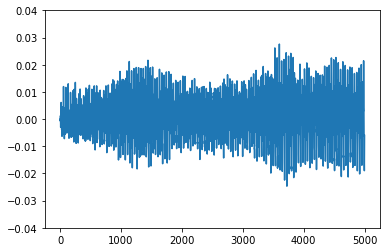

In [5]:
plot_wingbeat(train_dataset, idx=2)

In [6]:
if modeltype.startswith('drosophilatime'):
    model = DrosophilaNetTIME(outputs=outs, dropout_p=dropout_rate)
elif modeltype.startswith('inception'):
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Dropout(dropout_rate),
                    nn.Linear(in_features=4*32*1, out_features=outs))
elif modeltype.startswith('drosinception'):
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=16, 
                        kernel_sizes=[3, 23, 1023],
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=16*4, 
                        n_filters=32, 
                        kernel_sizes=[3, 23, 1023],
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Dropout(dropout_rate),
                    nn.Linear(in_features=4*32*1, out_features=outs))
    
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weight[0]/weight[1]]).cuda())#weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.25)
else:
    raise ValueError("Choose 1 or 2 for \'out\'")

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False, mode='triangular2')
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=True, mode="triangular")
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=0.000001, patience=5)

# Training

In [7]:
%time
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
                y_batch =  y_batch.unsqueeze(1)
                assert y_batch.shape[1] ==1
                assert pred.shape[1] ==1
                loss = criterion(pred, y_batch)
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
                loss = criterion(pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.

        # Going through the validation set
        correct_valid = 0
        model.eval()
        with torch.no_grad():
            for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
                y_batch = torch.as_tensor(y_batch)
                x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
                pred = model(x_batch)
                if outs == 1:
                    y_batch = y_batch.type(torch.FloatTensor).cuda()
                    correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
                    y_batch = y_batch.unsqueeze(1)
                    assert y_batch.shape[1] ==1
                    assert pred.shape[1] ==1
                    val_loss = criterion(pred, y_batch)
                elif outs == 2:
                    y_batch = y_batch.type(torch.LongTensor).cuda()
                    correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                    val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()
        
#         correct_test = 0
#         with torch.no_grad():
#             for x_batch,y_batch,_,_ in tqdm(test_dataloader, desc='Testing..\t'):
#                 y_batch = torch.as_tensor(y_batch)
#                 x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
#                 pred = model(x_batch)
#                 if outs == 1:
#                     y_batch = y_batch.type(torch.FloatTensor).cuda()
#                     correct_test += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
#                     y_batch = y_batch.unsqueeze(1)
#                     assert y_batch.shape[1] ==1
#                     assert pred.shape[1] ==1
#                 elif outs == 2:
#                     y_batch = y_batch.type(torch.LongTensor).cuda()
#                     correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
#         test_accuracy = correct_test / len(test_dataset) * 100.

            # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:4f},  val_loss: {val_loss:.4f} val_acc: {valid_accuracy:.1f}%")#, (test_acc:{test_accuracy:.1f}%)")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, f"model_{modeltype}")
elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs


In [8]:
model.eval();

# Results

## Controlled dataset - Test data

In [9]:
from utils import get_all_preds
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [10]:
dfctr = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=outs)
dfctr['tanh'] = torch.tanh(torch.Tensor(dfctr.pred)).numpy()
dfctr['sigmoid'] = torch.sigmoid(torch.Tensor(dfctr.pred)).numpy()

100%|██████████| 929/929 [00:08<00:00, 111.49it/s]


In [11]:
dfctr.to_csv(f'../data_created/dfctr_{pretrained_modelname}.csv')

### Controlled dataset - Validation data

In [12]:
dfctr_val = get_all_preds(model, valid_dataloader, dataframe=True, final_nodes=outs)
dfctr_val['tanh'] = torch.tanh(torch.Tensor(dfctr_val.pred)).numpy()
dfctr_val['sigmoid'] = torch.sigmoid(torch.Tensor(dfctr_val.pred)).numpy()

100%|██████████| 215/215 [00:02<00:00, 101.57it/s]


In [13]:
dfctr_val.to_csv(f'../data_created/dfctr_val_{pretrained_modelname}.csv')

## Remote-Uncontrolled dataset

In [14]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

dfunc = get_all_preds(model, extra_dataloader, dataframe=True, final_nodes=outs)
dfunc['tanh'] = torch.tanh(torch.Tensor(dfunc.pred)).numpy()
dfunc['sigmoid'] = torch.sigmoid(torch.Tensor(dfunc.pred)).numpy()

100%|██████████| 804/804 [00:06<00:00, 121.07it/s]


In [15]:
dfunc.to_csv(f'../data_created/dfunc_{pretrained_modelname}.csv')

## Loading results csv

In [16]:
sns.set(style='white')

if train_or_load_pretrained == 'train':
    df = pd.DataFrame(results)
    df['epoch'] = df.index.tolist()    
    df.to_csv(f"../data_created/{modeltype}_training_results.csv")
elif train_or_load_pretrained == 'load':
    df = pd.read_csv(f"../data_created/{modeltype}_training_results.csv")
    import re
    df['loss'] = df['loss'].apply(lambda x: round(float(x.replace('tensor(','').replace(')','')),6))
    df['val_loss'] = df['val_loss'].apply(lambda x: round(float(x.replace('tensor(','').replace(')','')),6))

In [17]:
def get_best_threshold(df):
#     precision, recall, thresholds = precision_recall_curve(df.y, df['sigmoid'] )
#     f1score = (2 * precision * recall) / (precision + recall)
#     # locate the index of the largest f score
#     ix = np.argmax(f1score)
#     print(f"Best Threshold={thresholds[ix]:.4f}, F1-Score={f1score[ix]:.2f}")
#     th = thresholds[ix]
#     return th
    threshold = []
    accuracy = []
    mat = df.sigmoid.values
    for p in tqdm(np.unique(mat), total=len(np.unique(mat))):
      threshold.append(p)
      y_pred = (mat > p).astype(int)
      accuracy.append(balanced_accuracy_score(df.y,y_pred))
    return threshold[np.argmax(accuracy)]

100%|██████████| 4120/4120 [00:56<00:00, 72.82it/s]


0.79966384

## Training Procedure Plots

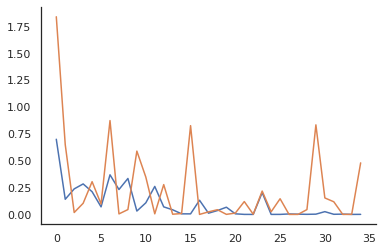

In [19]:
plt.plot(df.epoch, df.loss)
plt.plot(df.epoch, df.val_loss);
sns.despine()

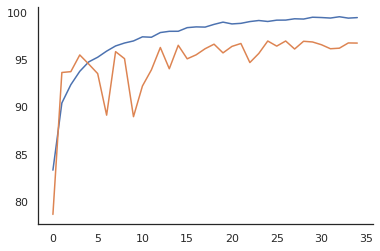

In [20]:
plt.plot(df.epoch, df.train_accuracy)
plt.plot(df.epoch, df.valid_accuracy);
sns.despine()

In [42]:
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
th = get_best_threshold(dfctr_val)

ROC AUC score: 0.97
Recall score: 0.96
Precision score: 0.85
Balanced accuracy: 0.89
Average precision score: 0.97
DrosophilaNet: ROC AUC=0.969


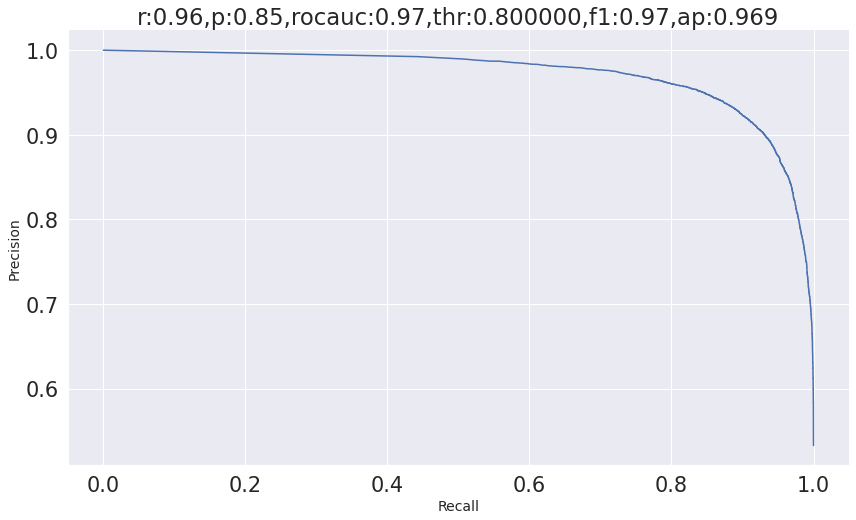

In [47]:
precision, recall, thresholds = precision_recall_curve(dfctr_val.y, dfctr_val['sigmoid'] )

f1score = (2 * precision * recall) / (precision + recall)
f1 = f1score[np.argmax(f1score)]
print(f"ROC AUC score: {roc_auc_score(y_true=dfctr.y, y_score=dfctr['sigmoid']):.2f}")

# THRESHOLDING (based on threshold found on validation data above)
dfctr['y_pred'] = dfctr['sigmoid'].apply(lambda x: 1 if x>=th else 0)
dfunc['y_pred'] = dfunc['sigmoid'].apply(lambda x: 1 if x>=th else 0)

recall_scr = recall_score(y_true=dfctr.y, y_pred=dfctr['y_pred'])
print(f"Recall score: {recall_scr:.2f}")
precision_scr = precision_score(y_true=dfctr.y, y_pred=dfctr['y_pred'])
print(f"Precision score: {precision_scr:.2f}")
balancedacc_scr = balanced_accuracy_score(y_true=dfctr.y, y_pred=dfctr['y_pred'])
print(f"Balanced accuracy: {balancedacc_scr:.2f}")
ap_scr = average_precision_score(y_true=dfctr.y, y_score=dfctr['sigmoid'])
print(f"Average precision score: {ap_scr:.2f}")

# calculate scores
auc = roc_auc_score(y_true=dfctr.y, y_score=dfctr['sigmoid'])
# summarize scores
print('DrosophilaNet: ROC AUC=%.3f' % (auc))
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true=dfctr.y, y_score=dfctr['sigmoid'])

plt.figure(figsize=(14,8))

precision, recall, thresholds = precision_recall_curve(dfctr.y, dfctr['sigmoid'] )
plt.plot(recall, precision)
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
sns.despine()
plt.title(f"r:{recall_scr:.2f},p:{precision_scr:.2f},rocauc:{auc:.2f},thr:{th:.6f},f1:{f1:.2f},ap:{ap_scr:.3f}")
sns.despine()

## Confusion Matrices

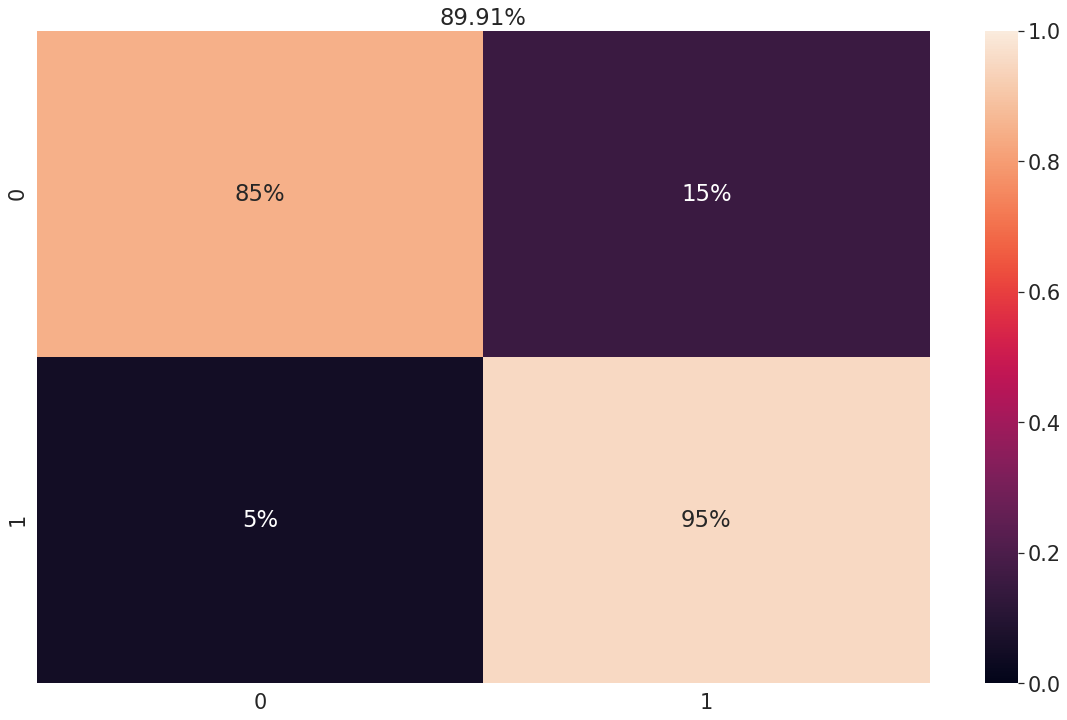

In [38]:
cm = confusion_matrix(y_true = dfctr.y, y_pred=dfctr['y_pred'], normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = dfctr.y, y_pred=dfctr['y_pred']):.2%}");

In [39]:
cm = confusion_matrix(y_true = dfctr.y, y_pred=dfctr['y_pred'], normalize=None)
cm

array([[11957,  2179],
       [  742, 14842]])

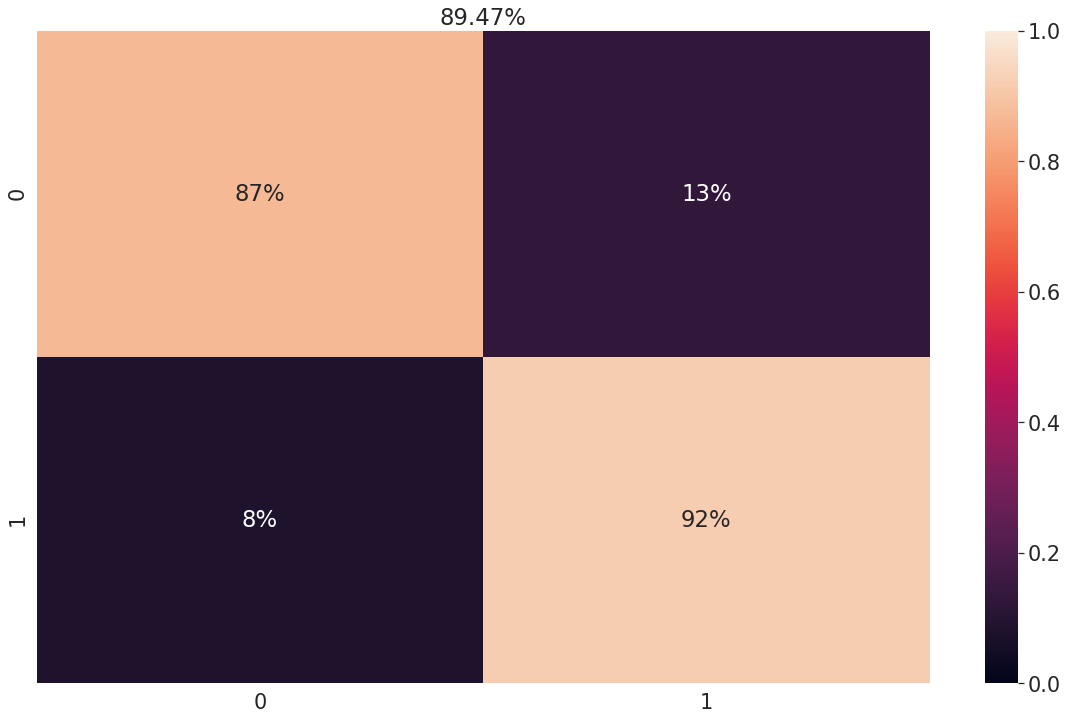

In [40]:
cm = confusion_matrix(y_true = dfunc.y, y_pred=dfunc['y_pred'], normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = dfunc.y, y_pred=dfunc['y_pred']):.2%}");

In [41]:
cm = confusion_matrix(y_true = dfunc.y, y_pred=dfunc['y_pred'], normalize=None)
cm

array([[ 1200,   182],
       [ 1918, 22414]])

## # of parameters

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
count_parameters(model)

8402433

## Inference Time

In [ ]:
pretrained_modelname

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)
for x_batch,y_batch,path_batch,idx_batch in dataloader:
    y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
    x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
    break
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    pred = model(x_batch)
print(prof)

In [ ]:
# DrosophilaNet
np.mean([5.160, 4.913, 4.640, 4.740, 4.634])

In [ ]:
# DrosophilaNet
np.mean([8.865, 7.489, 7.802, 7.520, 7.532])

In [ ]:
model